# Closure Phase & Systematic Bias in Multilooked InSAR Time-Series

**Author:** Yujie Zheng, May 2022

This notebook demonstrates a simple model explaining both the nonzero closure phase and systematic "bias" observed in small baseline InSAR time-series. The algorithm is implemented in the open-source software MintPy and available since version 1.4.0 as:

+ https://github.com/insarlab/MintPy/blob/main/src/mintpy/closure_phase_bias.py

Reference: The detailed algorithms can be found in the following paper:

+ Y. Zheng, H. Fattahi, P. Agram, M. Simons and P. Rosen, (2022), On Closure Phase and Systematic Bias in Multi-looked SAR Interferometry, in _IEEE Transactions on Geoscience and Remote Sensing, 60,_ doi: [10.1109/TGRS.2022.3167648](https://ieeexplore.ieee.org/document/9758802), [data](https://doi.org/10.5281/zenodo.6558341).

In the following, we use the Barstow-Bristol Trough, CA dataset (as shown in Zheng et al., 2022) as an example to illustrate the use of `closure_phase_bias.py`. This dataset includes interferograms generated from 153 Sentinel-1 A/B SAR images at descending orbit 173 using [ISCE2](https://github.com/isce-framework/isce2) / [topsStack](https://github.com/isce-framework/isce2/tree/main/contrib/stack/topsStack) processor (Rosen et al., 2012; Fattahi et al., 2017) developed at JPL/Caltech. The stack of interferograms is freely available on Zenodo at: https://doi.org/10.5281/zenodo.6558341 (size: 13 GB).

The average velocity maps of bw-1, bw-5, and bw-10 are shown in the figure below (right). Note that there are systematic descrepancies in these velocity maps. These descrepancies result from temporally inconsistent processes. We can use `closure_phase_bias.py` to estimate and remove these descrepancies.

<p align='left'>
    <img width="1000" src="../docs/drylake_cp_vel.jpg">
</p>
<p style="text-align: center;">
    (Figure from Zheng et al., 2022)
</p>

## Table of Contents

+ [Initial Setup](#Initial-Setup)
+ [closure_phase_bias.py - overview](#closure_phase_bias.py-overview)
+ [Option 1 - mask](#Option-1:---action-mask)
+ [Option 2 - quick_estimate](#Option-2:---action-quick_estimate)
+ [Option 3 - estimate](#Option-3:---action-estimate)
+ [Concluding Remarks](#Concluding-Remarks)

## Initial Setup

In [2]:
%matplotlib inline
import os
from mintpy.cli import view

# define and go to the work directory
work_dir = os.path.expanduser('~/data/DrylakeSenD173/mintpy')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download the example dataset
if not os.path.isdir('./inputs'):
    !wget https://zenodo.org/record/6558341/files/inputs.zip
    !unzip ./inputs.zip

Go to work directory: /Users/yunjunz/data/DrylakeSenD173/mintpy


## `closure_phase_bias.py` overview

In this script, we offer three options via `--action` option:

1. `mask` -- identify areas that are prone to temorally inconsistent processes, and create a map (mask).
2. `quick_estimate` -- an quick and approximate estimate of the "bias" time-series, assuming all interferograms within a bw-n analysis have the same temporal baseline.
3. `estimate` -- an estimate of the "bias" time-series as per introduced in Zheng et al. (2022).

Both option 2 and 3 will output sequential closure phase files and require complete con-1 and con-2 interferograms in the input `ifgramStack.h5`.

In [4]:
!closure_phase_bias.py --help

usage: closure_phase_bias.py [-h] [-i STACK_FILE] [--wm WATER_MASK_FILE]
                             [--nl NL] [--bw BW]
                             [-a {quick_estimate,estimate,mask}]
                             [--num-sigma NUM_SIGMA] [--eps EPSILON]
                             [-c {lsf,pbs,slurm,local}]
                             [--num-worker NUMWORKER] [--config CONFIG]
                             [--ram MAXMEMORY] [-o OUTDIR]

Phase non-closure related biases correction

optional arguments:
  -h, --help            show this help message and exit
  -i STACK_FILE, --ifgramstack STACK_FILE
                        interferogram stack file that contains the unwrapped phases
  --wm WATER_MASK_FILE, --water-mask WATER_MASK_FILE
                        Water mask to skip pixels on water body.
                        Default: waterMask.h5 if exists, otherwise None.
  --nl NL, --conn-level NL
                        connection level that we are correcting to (or consider as no bias)

## Option 1: `--action mask`

This is the most straightforward option amongst the three. The only input requirement is the `ifgramStack.h5` that contains the interferogram stack.

In [2]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 --nl 20 --num-sigma 2 -o . -a mask --ram 8


--------------------------------------------------------------------------------
calculating the mask to flag areas suseptible to non-closure-phase related biases (as zero) ...
number of valid acquisitions: 153 (20170203 - 20210101)
average complex closure phase threshold in amplitude/correlation: 0.3
average complex closure phase threshold in phase: 2.0 sigma (0.3 rad)

calculating the average complex closure phase
length / width: 1270 / 1125
maximum memory size: 8.0E+00 GB
split 1270 lines into 2 patches for processing
    with each patch up to 640 lines

------- processing patch 1 out of 2 --------------
box: (0, 0, 1125, 640)
box width:  1125
box length: 640
number of closure measurements expected: 133
number of closure measurements found   : 133
reference pixel in y/x: (751, 884) from dataset: unwrapPhase

------- processing patch 2 out of 2 --------------
box: (0, 640, 1125, 1270)
box width:  1125
box length: 630
number of closure measurements expected: 133
number of closure mea

After the above step, two files are created, following Fig. 5 in Zheng et al. (2022):

+ `avgCpxClosurePhase.h5`: contains the amplitude and phase of the complex number $\tau = 1/K \sum_{k=1}^K e^{j\Phi_k^{n_l}}$.
+ `maskClosurePhase.h5`: created by tresholding $|\tau|> 0.3$ and $|\angle\tau| > 2\sigma$, which are customizable via `--epsilon` and `--num-sigma` option.

In [3]:
# optional: create a valid data mask
!generate_mask.py  inputs/geometryRadar.h5 incidenceAngle -m 0.5 -o ValidDataMask.h5

input geometry file: inputs/geometryRadar.h5
read inputs/geometryRadar.h5 incidenceAngle
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
create HDF5 file: ValidDataMask.h5 with w mode
create dataset /mask of bool       in size of (1270, 1125)         with compression=None
finished writing to ValidDataMask.h5
time used: 00 mins 0.2 secs.


view.py ./avgCpxClosurePhase.h5 amplitude -v 0 1 -c gray --alpha 0.75 --noaxis --noverbose -m ValidDataMask.h5


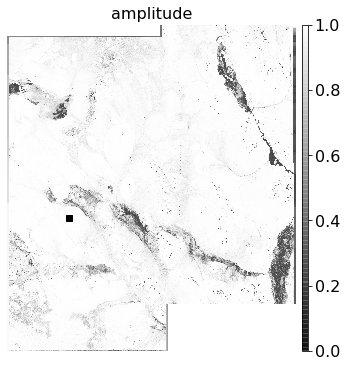

view.py ./avgCpxClosurePhase.h5 phase -v -1 1 -c vik --alpha 0.75 --noaxis --noverbose -m ValidDataMask.h5


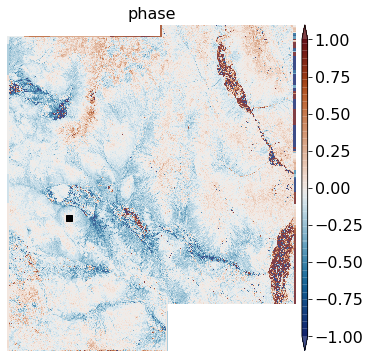

In [6]:
view.main('./avgCpxClosurePhase.h5 amplitude -v 0 1 -c gray --alpha 0.75 --noaxis --noverbose -m ValidDataMask.h5'.split())
view.main('./avgCpxClosurePhase.h5 phase -v -1 1 -c vik --alpha 0.75 --noaxis --noverbose -m ValidDataMask.h5'.split())

view.py ./maskClosurePhase.h5 -c gray --alpha 0.75 --noaxis --nocbar --noverbose -m ValidDataMask.h5


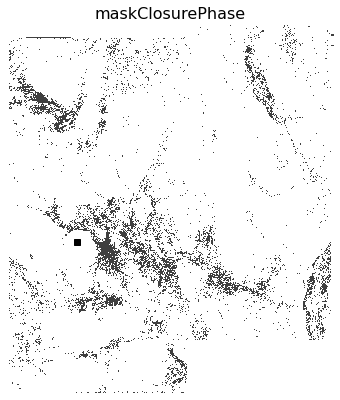

In [7]:
view.main('./maskClosurePhase.h5 -c gray --alpha 0.75 --noaxis --nocbar --noverbose -m ValidDataMask.h5'.split())

## Option 2: `--action quick_estimate`

This option has more requirements than option 1 for two reasons:

1. This option generates a new folder called `closurePhase` in which we will output closure phases with different connection levels.
2. This option requires that `ifgramStack.h5` should be **complete in terms of interferograms of connection level below your analysis bandwidth**. For example, in our case, we have 153 SAR aquisitions, and we would like to correct a bw-1 analysis, and we set $n_l=20$. In order for this option to work properly, we need to have 152 con-1 and 133 con-20 interferograms stored in ifgramStack.h5. In addition, we also need 151 con-2 interferograms to provide higher temporal resolution. Missing interferograms can cause problems for this code.

Comparing to option 3, this option is simlified in terms of the structure of the weight matrix $W$ (Eq.16 in Zheng et al. 2022). In other words, we are ignoring the differences in the diagnoal components of $W$, and simplifying it as:

$$W = w(\Delta t) I$$

where $I$ is an identity matrix, $\Delta t$ is the average temoral span of interferograms for a given time-series anlaysis.

In the following we estimate and correct bw-5 time-series with both option 2 and option 3. bw-1 and bw-10 time-series corrections follow the exact same steps and are left as an exercise for the readers.

In [8]:
 !closure_phase_bias.py -i inputs/ifgramStack.h5 --bw 5 --nl 20 -a quick_estimate --ram 8 -o .


--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 2 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn2/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 3 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn3/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 4 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn4/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the

This step generates the following folders and files:

+ `closurePhase`: directory contains sub-folders that stores wrapped and unwrapped closure phases at different connection level.
+ `wratio.h5`: file that contains two datasets: `wratio` and `velocityBias`
   - `wratio-n`: the $n$-th diagonal component of $W^r$ (Eq.20 in Zheng et al., 2022), a.k.a., $w(n\delta_t) / w(\delta_t)$
   - `velocityBias-n`: bias velocity in connection-n interferograms
+ `timeseriesBiasApprox.h5`: a timeseries file for the estimated bias time-series

To get the bias velocity map, or correct bias time-series from the original time-series, use `timeseries2velocity.py` and `diff.py` in MintPy.

In [9]:
# create a mask that combines the temporal coherence threshold of 0.8 of the bw-5 analysis and the connected components from unwrapping con-20 sequential closure phases
!mask.py bw5/maskTempCoh.h5 -m closurePhase/conn20/maskConnComp.h5 -o mask_velocity.h5

masking mask from bw5/maskTempCoh.h5 ...
in order to fill the invalid pixels with np.nan
	convert input matrix from bool to np.float32
delete exsited file: mask_velocity.h5
create HDF5 file: mask_velocity.h5 with w mode
create dataset /mask of float32    in size of (1270, 1125)         with compression=None
finished writing to mask_velocity.h5
Done.


view.py wratio.h5 velocityBias-1 -c vik -v -0.5 0.5 -u cm --cbar-label cm/yr -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


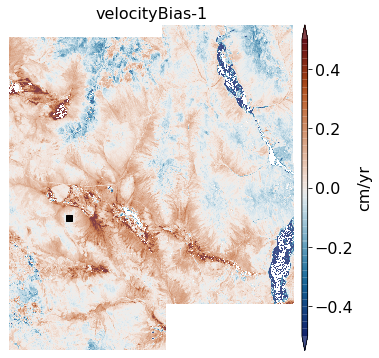

In [10]:
# map of bias velocity at connection-1 level interferograms (Fig.7(a) in Zheng et al., TGRS, 2022)
view.main('wratio.h5 velocityBias-1 -c vik -v -0.5 0.5 -u cm --cbar-label cm/yr -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

view.py wratio.h5 wratio-2 -c gray -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


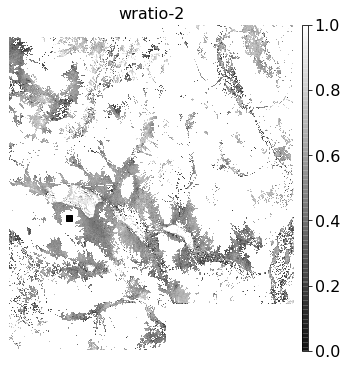

In [11]:
# map of Wratio-2, the second diagnoal component of W^r (w(2\delta_t)/w(delta_t) (Eq.[20] Zheng et al., TGRS, 2022)
view.main('wratio.h5 wratio-2 -c gray -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

In [10]:
# calculate bias velocity of bw-5 analysis from the approximate bias timeseries
!timeseries2velocity.py timeseriesBiasApprox.h5 -o velocity_bias_approx.h5
# correct original time-series
!diff.py bw5/timeseries.h5 timeseriesBiasApprox.h5 -o timeseries_cor_approx.h5
# calculate corrected velocity of bw-5 analysis
!timeseries2velocity.py timeseries_cor_approx.h5 -o velocity_cor_approx.h5

open timeseries file: timeseriesBiasApprox.h5
--------------------------------------------------
dates from input file: 153
['20170203', '20170227', '20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903',

view.py bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


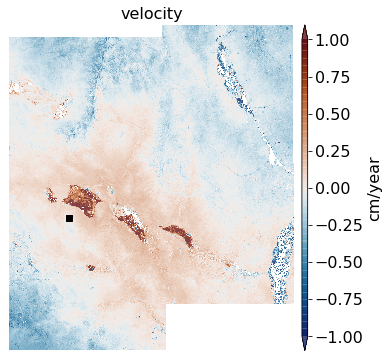

view.py bias_velocity_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


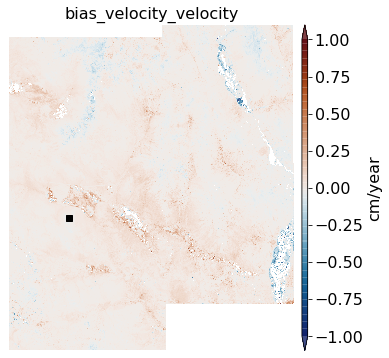

view.py velocity_cor_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


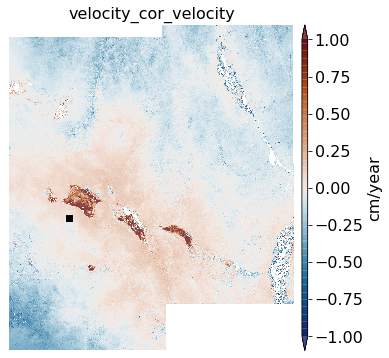

In [23]:
# map of original velocity in a bw-5 analysis
view.main('bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of bias velocity in a bw-5 analysis
view.main('velocity_bias_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of corrected velocity of a bw-5 analysis
view.main('velocity_cor_approx.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

## Option 3: `--action estimate`

This option implements the exact algorithm as presented in Zheng et al. (2022), without approximation. Note that it is important to use `modify_network.py` to make the maximum connection level in `ifgramStack.h5` consistent with the input bandwidth (`--bw`).

In [24]:
!modify_network.py inputs/ifgramStack.h5 --max-conn-num 5

open ifgramStack file: ifgramStack.h5
number of interferograms: 1608
--------------------------------------------------
Drop ifgrams with temporal baseline beyond 5 neighbors: (858)
--------------------------------------------------
number of interferograms to remove: 858
number of interferograms to keep  : 750
Calculated date12 to drop is the same as exsiting marked input file, skip updating file.


In [25]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 --bw 5 --nl 20 -a estimate -o . --num-worker 6 -c local


--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 2 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn2/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 3 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn3/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the unwrapped closure phase for connection level = 4 out of [2, 3, 4, 5, 20] ...
cumulative unwrapped seq closure phase time-series exists at: ./closurePhase/conn4/cumSeqClosurePhase.h5, skip re-generating.

--------------------------------------------------------------------------------
calculating the

This step generates a new HDF5 file:

+ `timeseriesBias.h5`: a timeseries file that contains the bias time series of the bandwidth small baseline InSAR time series.

In [26]:
# calculate bias velocity of bw-5 analysis from the bias timeseries
!timeseries2velocity.py timeseriesBias.h5 -o velocity_bias.h5
# correct original time-series
!diff.py bw5/timeseries.h5 timeseriesBias.h5 -o timeseries_cor.h5
# calculate corrected velocity of bw-5 analysis
!timeseries2velocity.py timeseries_cor.h5 -o velocity_cor.h5

open timeseries file: timeseriesBias.h5
--------------------------------------------------
dates from input file: 153
['20170203', '20170227', '20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903', '2019

view.py bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


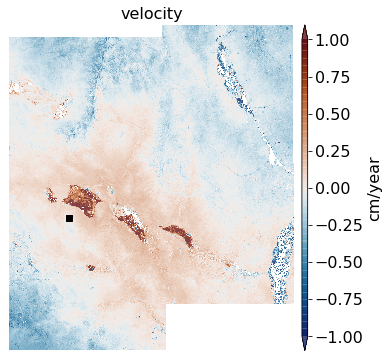

view.py bias_velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


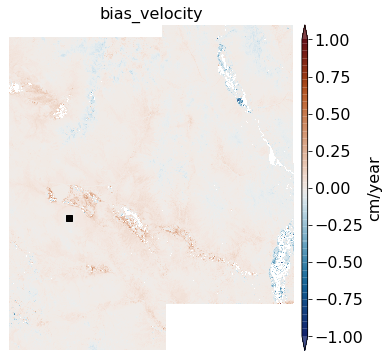

view.py velocity_cor.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose


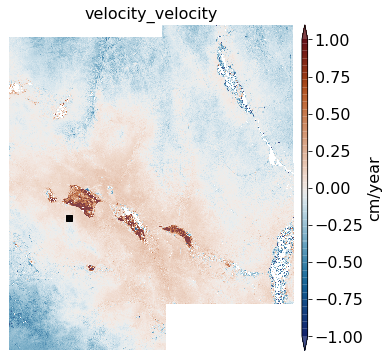

In [27]:
# map of original velocity in a bw-5 analysis
view.main('bw5/velocity.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of bias velocity in a bw-5 analysis
view.main('velocity_bias.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())
# map of corrected velocity of a bw-5 analysis
view.main('velocity_cor.h5 velocity -c vik -v -1 1 -m mask_velocity.h5 --alpha 0.75 --noaxis --noverbose'.split())

## Concluding Remarks

- The folder `closurePhase` only needs to be calculated once. 
- We recommend trying action `quick_estimate` before action `estimate`. In our case, you can see that these two solutions are very close. What's more, option 2 also generates `wratios.h5`, which allow you to exam whether your choice of $n_l$ is reasonable (by seeing whether the diagnoal components of $W^r$ (wratio-n) fades quickly).